In [1]:
import os, time, requests, tempfile, numpy as np, nibabel as nib
from typing import List, Optional

class OpenNeuroStreamer:
    def __init__(self, dataset_id: str = "ds002306"):
        self.dataset_id = dataset_id
        self.base_url = f"https://s3.amazonaws.com/openneuro.org/{dataset_id}"

    def check_url_exists(self, url: str) -> bool:
        try:
            response = requests.head(url, timeout=15)
            return response.status_code == 200
        except:
            return False

    def stream_nii_file(self, url: str) -> Optional[np.ndarray]:
        print(f"Streaming: {os.path.basename(url)}")
        temp_path = None
        try:
            response = requests.get(url, stream=True, timeout=120)
            response.raise_for_status()
            with tempfile.NamedTemporaryFile(suffix='.nii.gz', delete=False) as temp_file:
                temp_path = temp_file.name
                for chunk in response.iter_content(chunk_size=8192):
                    temp_file.write(chunk)
            img = nib.load(temp_path)
            return img.get_fdata(dtype=np.float32)
        except Exception as e:
            print(f"Error streaming file: {e}")
            return None
        finally:
            if temp_path and os.path.exists(temp_path):
                os.unlink(temp_path)

    def load_selected_files(self):
        selected_files = [
            ("sub-01", range(1, 6)), 
            ("sub-02", range(1, 6)),  
            ("sub-03", range(1, 3))   
        ]

        data = []
        for subject, runs in selected_files:
            for run in runs:
                url = f"{self.base_url}/{subject}/func/{subject}_task-training_run-{run:02d}_bold.nii.gz"
                if self.check_url_exists(url):
                    d = self.stream_nii_file(url)
                    if d is not None:
                        data.append(d)
        return data


# === RUN THE DOWNLOADER ===
print("NOTEBOOK 1A: Downloading Specific Files (sub-01 to sub-03, run-02)")
streamer = OpenNeuroStreamer()
chunk_data = streamer.load_selected_files()
if chunk_data:
    np.save("/kaggle/working/fmri_dataset_chunk_1.npy", np.array(chunk_data, dtype=np.float32))
    print("\nChunk saved successfully.")


NOTEBOOK 1A: Downloading Specific Files (sub-01 to sub-03, run-02)
Streaming: sub-01_task-training_run-01_bold.nii.gz
Streaming: sub-01_task-training_run-02_bold.nii.gz
Streaming: sub-01_task-training_run-03_bold.nii.gz
Streaming: sub-01_task-training_run-04_bold.nii.gz
Streaming: sub-01_task-training_run-05_bold.nii.gz
Streaming: sub-02_task-training_run-01_bold.nii.gz
Streaming: sub-02_task-training_run-02_bold.nii.gz
Streaming: sub-02_task-training_run-03_bold.nii.gz
Streaming: sub-02_task-training_run-04_bold.nii.gz
Streaming: sub-02_task-training_run-05_bold.nii.gz
Streaming: sub-03_task-training_run-01_bold.nii.gz
Streaming: sub-03_task-training_run-02_bold.nii.gz

Chunk saved successfully.


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, ReLU,LeakyReLU, BatchNormalization, Concatenate, Layer, Flatten, Dense
from tensorflow.keras.models import Model
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import gc

2025-07-02 16:37:59.247621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751474279.477073      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751474279.541438      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
def load_fmri_data(file_path):
    print(f"Loading fMRI data from {file_path}")
    img = nib.load(file_path)
    data = img.get_fdata()
    affine = img.affine

    print(f"fMRI data shape: {data.shape}")
    return data, affine

In [5]:
def add_noise(data, noise_factor=0.1):
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=data.shape)
    return data + noise

def preprocess_data(data, noise_factor=0.15, max_timepoints=30):
    data_min = data.min()
    data_max = data.max()
    data_norm = (data - data_min) / (data_max - data_min + 1e-8)

    x, y, z, t = data_norm.shape
    print(f"Preprocessing full volumes from shape {data_norm.shape}")

    time_points = np.linspace(0, t - 1, min(t, max_timepoints), dtype=int)

    clean_volumes = []
    noisy_volumes = []

    for time in time_points:
        vol = data_norm[:, :, :, time]
        if np.mean(vol) > 0.01:  # Skip empty frames
            clean_volumes.append(vol[..., np.newaxis])  # Add channel axis
            noisy_volumes.append(add_noise(vol, noise_factor)[..., np.newaxis])

    clean_volumes = np.array(clean_volumes, dtype=np.float32)
    noisy_volumes = np.array(noisy_volumes, dtype=np.float32)

    print(f"Created {len(clean_volumes)} full volumes of shape {clean_volumes[0].shape}")
    return noisy_volumes, clean_volumes, (data_min, data_max)

In [6]:
def build_generator(input_shape):
    inputs = Input(shape=input_shape)
    x = inputs
    skips = []

    filters = [32,64,128]  # Reduced filter sizes

    # Downsampling
    for f in filters:
        skips.append(x)  # save skip BEFORE downsampling conv
        x = Conv3D(f, 3, strides=2, padding="same")(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)


    # Bottleneck
    x = Conv3D(128, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # Upsampling
    for f, skip in zip(reversed(filters), reversed(skips)):
        x = Conv3DTranspose(f, 3, strides=2, padding="same")(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Concatenate()([x, skip])

    outputs = Conv3D(1, 1, padding="same", activation="sigmoid")(x)
    return Model(inputs, outputs, name="Generator")


In [7]:
def build_critic(input_shape):
    inputs = Input(shape=input_shape)
    x = inputs

    filters = [32, 64, 128,256]  # Reduced and capped filters

    for i, f in enumerate(filters):
        x = Conv3D(f, 3, strides=2, padding="same")(x)
        if i > 0:  # Avoid batch norm on first layer
            x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    return Model(inputs, x, name="Critic")


In [8]:
class GradientPenaltyLayer(Layer):
    def __init__(self, critic, gp_weight=10.0, **kwargs):
        super(GradientPenaltyLayer, self).__init__(**kwargs)
        self.critic = critic
        self.gp_weight = gp_weight

    def call(self, inputs):
        real_images, fake_images = inputs
        batch_size = tf.shape(real_images)[0]

        alpha = tf.random.uniform([batch_size, 1, 1, 1, 1], 0.0, 1.0)
        interpolated = alpha * real_images + (1 - alpha) * fake_images

        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        gradients = tape.gradient(pred, interpolated)
        gradients_squared = tf.square(gradients)
        gradients_squared_sum = tf.reduce_sum(gradients_squared, axis=[1, 2, 3, 4])
        gradient_l2_norm = tf.sqrt(gradients_squared_sum)
        gradient_penalty = self.gp_weight * tf.square(gradient_l2_norm - 1.0)

        return tf.reduce_mean(gradient_penalty)


In [9]:
class UWGAN(keras.Model):
    def __init__(self, input_shape, critic_extra_steps=3, gp_weight=10.0):
        super(UWGAN, self).__init__()
        self.input_shape = input_shape

        self.generator = build_generator(input_shape)
        self.critic = build_critic(input_shape)

        self.critic_extra_steps = critic_extra_steps
        self.gp_weight = gp_weight
        self.gp_layer = GradientPenaltyLayer(self.critic, gp_weight)

        self.generator_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
        self.critic_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

        self.generator.summary()
        self.critic.summary()

    def compile(self, **kwargs):
        super(UWGAN, self).compile(**kwargs)

    @tf.function
    def train_critic(self, noisy_images, real_images):
      noisy_images = tf.cast(noisy_images, tf.float32)
      real_images = tf.cast(real_images, tf.float32)

      with tf.GradientTape() as tape:
        fake_images = self.generator(noisy_images, training=True)

        real_output = self.critic(real_images, training=True)
        fake_output = self.critic(fake_images, training=True)

        critic_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

        gp = self.gp_layer([real_images, fake_images])
        critic_loss += gp

      gradients = tape.gradient(critic_loss, self.critic.trainable_variables)
      self.critic_optimizer.apply_gradients(zip(gradients, self.critic.trainable_variables))
      return critic_loss

    @tf.function
    def train_generator(self, noisy_images):
      noisy_images = tf.cast(noisy_images, tf.float32)
      with tf.GradientTape() as tape:
        fake_images = self.generator(noisy_images, training=True)

        fake_output = self.critic(fake_images, training=True)

        gen_loss = -tf.reduce_mean(fake_output)

        l1_loss = tf.reduce_mean(tf.abs(fake_images - noisy_images)) * 100.0
        total_gen_loss = gen_loss + l1_loss

      gradients = tape.gradient(total_gen_loss, self.generator.trainable_variables)
      self.generator_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
      return total_gen_loss, gen_loss, l1_loss

    @tf.function
    def train_step(self, data,jit_compile=False):
        noisy_images, real_images = data

        for i in range(self.critic_extra_steps):
            c_loss = self.train_critic(noisy_images, real_images)

        g_loss, g_wasserstein, g_l1 = self.train_generator(noisy_images)

        results = {
            'critic_loss': c_loss,
            'gen_loss': g_loss,
            'wasserstein_loss': g_wasserstein,
            'l1_loss': g_l1
        }
        return results


In [14]:
def train_model(model, noisy_patches, clean_patches, batch_size=64, epochs=50):
    train_dataset = tf.data.Dataset.from_tensor_slices((noisy_patches, clean_patches))
    train_dataset = train_dataset.shuffle(buffer_size=len(noisy_patches)).batch(batch_size)

    class VisualizeCallback(tf.keras.callbacks.Callback):
        def __init__(self, noisy_patches, clean_patches):
            super().__init__()
            noisy_patches = np.array(noisy_patches)
            clean_patches = np.array(clean_patches)
    
            n_samples = min(2, len(noisy_patches))
            vis_idx = np.random.randint(0, len(noisy_patches), n_samples)
    
            self.vis_noisy = noisy_patches[vis_idx]
            self.vis_clean = clean_patches[vis_idx]

        def on_epoch_end(self, epoch, logs=None):
            if (epoch + 1) % 5 == 0 or epoch == 0:
                denoised_vis = self.model.generator.predict(self.vis_noisy)
                plt.figure(figsize=(12, 8))

                for i in range(len(self.vis_noisy)):
                    slice_idx = self.vis_noisy[i].shape[2] // 2

                    plt.subplot(3, len(self.vis_noisy), i + 1)
                    plt.imshow(self.vis_noisy[i, :, :, slice_idx, 0], cmap='gray')
                    plt.title('Noisy')
                    plt.axis('off')

                    plt.subplot(3, len(self.vis_noisy), i + 1 + len(self.vis_noisy))
                    plt.imshow(denoised_vis[i, :, :, slice_idx, 0], cmap='gray')
                    plt.title('Denoised')
                    plt.axis('off')

                    plt.subplot(3, len(self.vis_noisy), i + 1 + 2*len(self.vis_noisy))
                    plt.imshow(self.vis_clean[i, :, :, slice_idx, 0], cmap='gray')
                    plt.title('Clean')
                    plt.axis('off')

                plt.tight_layout()
                plt.savefig(f"denoised_epoch_{epoch+1}.png")
                plt.close()

    model.compile()

    vis_callback = VisualizeCallback(noisy_patches, clean_patches)

    history = model.fit(
        train_dataset,
        epochs=epochs,
        callbacks=[vis_callback],
        verbose=1
    )

    return history.history

In [21]:
npy_file_path = "/kaggle/working/fmri_dataset_chunk_1.npy"
all_data = np.load(npy_file_path)  # Shape: (N, H, W, D, T)

all_clean_patches = []
all_noisy_patches = []

print(f"Loaded {all_data.shape[0]} fMRI volumes.")

Loaded 12 fMRI volumes.


In [ ]:
for i, data in enumerate(all_data):
    print(f"Preprocessing volume {i+1}/{len(all_data)}")
    clean_patches, noisy_patches, norm_params = preprocess_data(data, patch_size)
    all_clean_patches.extend(clean_patches)
    all_noisy_patches.extend(noisy_patches)

In [ ]:
all_noisy_patches = all_noisy_patches[..., np.newaxis]
all_clean_patches = all_clean_patches[..., np.newaxis] 

In [ ]:
volume_shape = all_clean_volumes[0].shape
print(f"Training with volume shape: {volume_shape}, total volumes: {len(all_clean_volumes)}")

In [28]:
def extract_patches(volume, patch_size=(64,64,64), stride=(64,64,64)):
    patches = []
    x_max, y_max, z_max = volume.shape[:3]
    px, py, pz = patch_size
    sx, sy, sz = stride

    for x in range(0, x_max - px + 1, sx):
        for y in range(0, y_max - py + 1, sy):
            for z in range(0, z_max - pz + 1, sz):
                patch = volume[x:x+px, y:y+py, z:z+pz]
                patches.append(patch)
    return np.array(patches)

In [30]:
# Preprocess full volumes (no patches inside this function)
noisy_volumes, clean_volumes, norm_params = preprocess_data(data, noise_factor=0.15)

# Then extract patches from he volumes
for noisy_vol, clean_vol in zip(noisy_volumes, clean_volumes):
    noisy_patches = extract_patches(noisy_vol[..., 0], patch_size=(64,64,64), stride=(64,64,64))
    clean_patches = extract_patches(clean_vol[..., 0], patch_size=(64,64,64), stride=(64,64,64))
    
    all_noisy_patches.extend(noisy_patches)
    all_clean_patches.extend(clean_patches)

Preprocessing full volumes from shape (96, 96, 72, 281)
Created 30 full volumes of shape (96, 96, 72, 1)


In [31]:
def extract_patches(volume, patch_size=(64,64,64), stride=(32,32,32)):
    patches = []
    x_max, y_max, z_max = volume.shape[:3]
    px, py, pz = patch_size
    sx, sy, sz = stride
    
    for x in range(0, x_max - px + 1, sx):
        for y in range(0, y_max - py + 1, sy):
            for z in range(0, z_max - pz + 1, sz):
                patch = volume[x:x+px, y:y+py, z:z+pz]
                patches.append(patch)
    return patches

all_clean_patches = []
all_noisy_patches = []

for noisy_vol, clean_vol in zip(noisy_volumes, clean_volumes):
    noisy_vol = noisy_vol[..., 0]  # remove channel dim if needed
    clean_vol = clean_vol[..., 0]
    
    noisy_patches = extract_patches(noisy_vol, patch_size=(64,64,64), stride=(32,32,32))
    clean_patches = extract_patches(clean_vol, patch_size=(64,64,64), stride=(32,32,32))
    
    all_noisy_patches.extend(noisy_patches)
    all_clean_patches.extend(clean_patches)


In [36]:
patch_shape = all_clean_patches[0].shape
model_2 = UWGAN(patch_shape, critic_extra_steps=2, gp_weight=10.0)
history = train_model(model_2, all_noisy_patches, all_clean_patches, batch_size=4, epochs=50)

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 64, 64, 64, 1)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_40 (Conv3D)        │ (None, 32, 32, 32, 16) │            448 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_45    │ (None, 32, 32, 32, 16) │             64 │ conv3d_40[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_36            │ (None, 32, 32, 32, 16) │              0 │ batch_normalization_4… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_41 (Conv3D)        │ (None, 16, 16, 16, 32) │         13,856 │ leaky_re_lu_36[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_46    │ (None, 16, 16, 16, 32) │            128 │ conv3d_41[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_37            │ (None, 16, 16, 16, 32) │              0 │ batch_normalization_4… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_42 (Conv3D)        │ (None, 8, 8, 8, 64)    │         55,360 │ leaky_re_lu_37[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_47    │ (None, 8, 8, 8, 64)    │            256 │ conv3d_42[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_38            │ (None, 8, 8, 8, 64)    │              0 │ batch_normalization_4… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_43 (Conv3D)        │ (None, 8, 8, 8, 128)   │        221,312 │ leaky_re_lu_38[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_48    │ (None, 8, 8, 8, 128)   │            512 │ conv3d_43[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_39            │ (None, 8, 8, 8, 128)   │              0 │ batch_normalization_4… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_transpose_13       │ (None, 16, 16, 16, 64) │        221,248 │ leaky_re_lu_39[0][0]   │
│ (Conv3DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 617,378 (2.36 MB)

 Trainable params: 616,674 (2.35 MB)

 Non-trainable params: 704 (2.75 KB)

Model: "Critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 64, 64, 64, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_45 (Conv3D)                   │ (None, 32, 32, 32, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_40 (LeakyReLU)           │ (None, 32, 32, 32, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_46 (Conv3D)                   │ (None, 16, 16, 16, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_52               │ (None, 16, 16, 16, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_41 (LeakyReLU)           │ (None, 16, 16, 16, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_47 (Conv3D)                   │ (None, 8, 8, 8, 64)         │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 8, 8, 8, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_42 (LeakyReLU)           │ (None, 8, 8, 8, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_48 (Conv3D)                   │ (None, 4, 4, 4, 128)        │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 4, 4, 4, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_43 (LeakyReLU)           │ (None, 4, 4, 4, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 300,065 (1.14 MB)

 Trainable params: 299,617 (1.14 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/stepp - critic_loss: 51.8428 - gen_loss: 42.5856 - l1_loss: 43.0753 - wasserstein_loss: -0.48
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - critic_loss: 50.2213 - gen_loss: 42.4639 - l1_loss: 42.9649 - wasserstein_loss: -0.5010
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - critic_loss: -0.1355 - gen_loss: 33.9498 - l1_loss: 34.3731 - wasserstein_loss: -0.4233
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - critic_loss: -0.4953 - gen_loss: 29.0190 - l1_loss: 28.8860 - wasserstein_loss: 0.1329
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - critic_loss: -1.0775 - gen_loss: 27.1019 - l1_loss: 26.3387 - wasserstein_loss: 0.7632
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/stepep - critic_loss: -1.7531 - gen_loss: 26.5004 - l1_loss: 24.9598 - wasserstein_loss: 1.540
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - critic_loss: -1.7749 - gen_loss: 26.5103 - l1_loss: 24.9527 - wasserstein_loss: 1.5576
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s

In [38]:
history_more = train_model(model_2, all_noisy_patches, all_clean_patches, batch_size=4, epochs=50)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/stepep - critic_loss: -6.1713 - gen_loss: 13.0180 - l1_loss: 12.6510 - wasserstein_loss: 0.366
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - critic_loss: -6.2125 - gen_loss: 13.0076 - l1_loss: 12.6510 - wasserstein_loss: 0.3566
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - critic_loss: -5.6384 - gen_loss: 12.6899 - l1_loss: 12.5955 - wasserstein_loss: 0.0944
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - critic_loss: -5.3659 - gen_loss: 12.4265 - l1_loss: 12.5501 - wasserstein_loss: -0.1236
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - critic_loss: -5.3213 - gen_loss: 12.1377 - l1_loss: 12.5084 - wasserstein_loss: -0.3706
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/stepep - critic_loss: -5.2568 - gen_loss: 11.8571 - l1_loss: 12.4703 - wasserstein_loss: -0.613
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - critic_loss: -5.2630 - gen_loss: 11.8550 - l1_loss: 12.4691 - wasserstein_loss: -0.6141
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2

In [41]:
history_more_2 = train_model(model_2, all_noisy_patches, all_clean_patches, batch_size=4, epochs=100)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/stepep - critic_loss: -27.6014 - gen_loss: 8.6554 - l1_loss: 8.3661 - wasserstein_loss: 0.289
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - critic_loss: -27.6047 - gen_loss: 8.6620 - l1_loss: 8.3667 - wasserstein_loss: 0.2953
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - critic_loss: -30.9519 - gen_loss: 8.8832 - l1_loss: 8.3679 - wasserstein_loss: 0.5153
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - critic_loss: -26.7381 - gen_loss: 8.7834 - l1_loss: 8.3851 - wasserstein_loss: 0.3983
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/stepep - critic_loss: -26.2621 - gen_loss: 7.1744 - l1_loss: 8.4142 - wasserstein_loss: -1.239
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - critic_loss: -23.9174 - gen_loss: 7.1580 - l1_loss: 8.4166 - wasserstein_loss: -1.2586
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - critic_loss: -11.9154 - gen_loss: 8.0015 - l1_loss: 8.5729 - wasserstein_loss: -0.5713
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [19]:
print("Loading all fMRI volumes from .npy file...")
fmri_volumes = np.load("/kaggle/working/fmri_dataset_chunk_1.npy", allow_pickle=True)

all_clean_patches = []
all_noisy_patches = []

for i, data in enumerate(fmri_volumes):
    print(f"\nProcessing sample {i+1}/{len(fmri_volumes)} - shape: {data.shape}")
    
    try:
        clean_patches, noisy_patches, _ = preprocess_data(data, patch_size=(32, 32, 8))
        all_clean_patches.extend(clean_patches)
        all_noisy_patches.extend(noisy_patches)
    except Exception as e:
        print(f"Skipping sample {i} due to error: {e}")

all_clean_patches = np.array(all_clean_patches, dtype=np.float32)
all_noisy_patches = np.array(all_noisy_patches, dtype=np.float32)

print(f"\n✅ Total clean patches: {all_clean_patches.shape}")
print(f"✅ Total noisy patches: {all_noisy_patches.shape}")


Loading all fMRI volumes from .npy file...

Processing sample 1/12 - shape: (96, 96, 72, 281)
Preprocessing data of shape (96, 96, 72, 281)
Using patch size: (32, 32, 8)
Created 504 patches of shape (32, 32, 8, 1)

Processing sample 2/12 - shape: (96, 96, 72, 281)
Preprocessing data of shape (96, 96, 72, 281)
Using patch size: (32, 32, 8)
Created 504 patches of shape (32, 32, 8, 1)

Processing sample 3/12 - shape: (96, 96, 72, 281)
Preprocessing data of shape (96, 96, 72, 281)
Using patch size: (32, 32, 8)
Created 500 patches of shape (32, 32, 8, 1)

Processing sample 4/12 - shape: (96, 96, 72, 281)
Preprocessing data of shape (96, 96, 72, 281)
Using patch size: (32, 32, 8)
Created 500 patches of shape (32, 32, 8, 1)

Processing sample 5/12 - shape: (96, 96, 72, 281)
Preprocessing data of shape (96, 96, 72, 281)
Using patch size: (32, 32, 8)
Created 500 patches of shape (32, 32, 8, 1)

Processing sample 6/12 - shape: (96, 96, 72, 281)
Preprocessing data of shape (96, 96, 72, 281)
Using

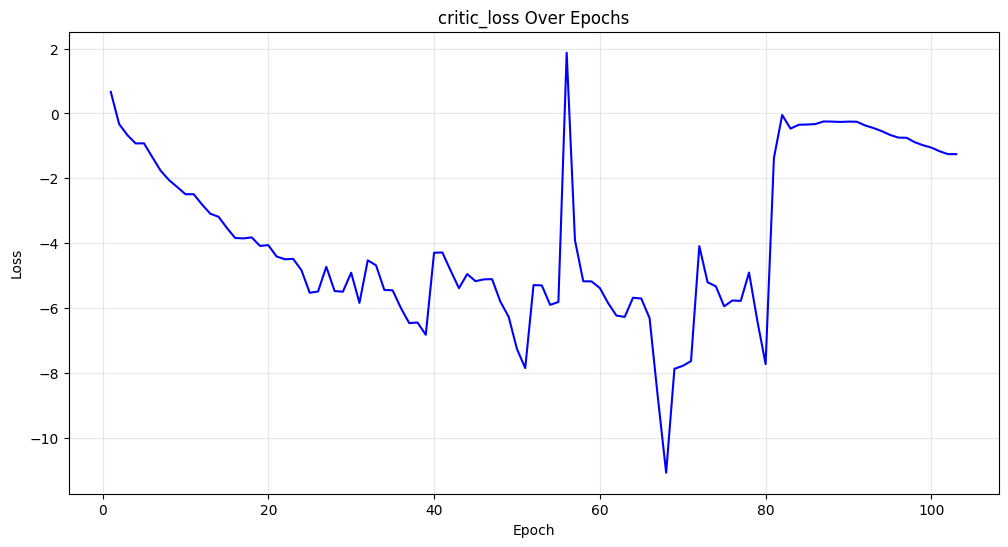

In [3]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(critic_loss) + 1))

plt.figure(figsize=(12, 6))
plt.plot(epochs, critic_loss, 'b-', linewidth=1.5)
plt.title('critic_loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

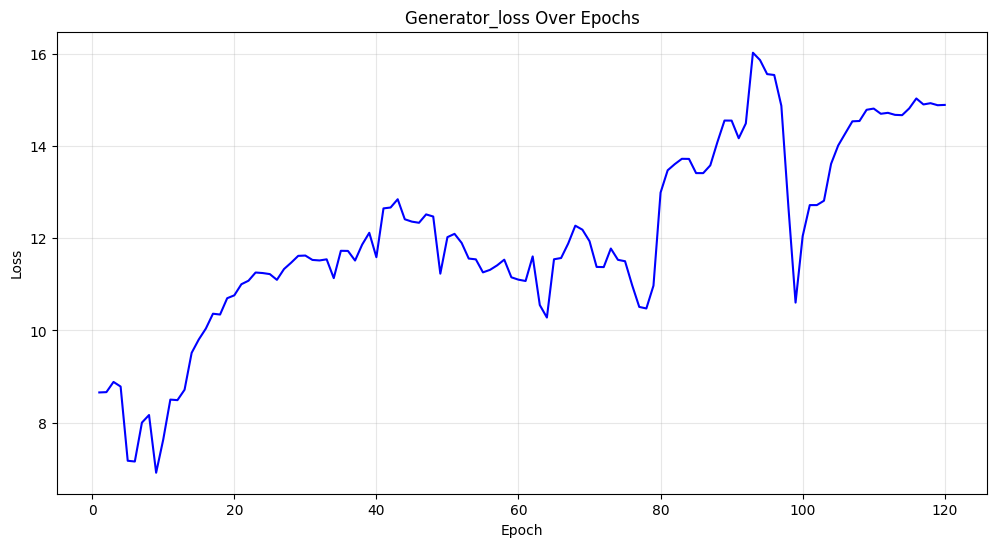

In [5]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(generator_loss) + 1))

plt.figure(figsize=(12, 6))
plt.plot(epochs, generator_loss, 'b-', linewidth=1.5)
plt.title('Generator_loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

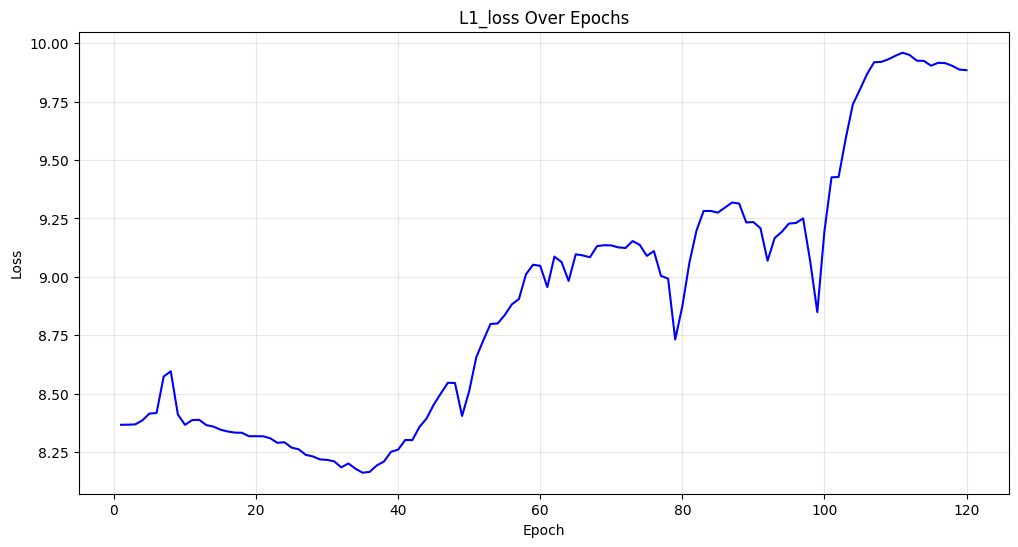

In [6]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(L1_loss) + 1))

plt.figure(figsize=(12, 6))
plt.plot(epochs, L1_loss, 'b-', linewidth=1.5)
plt.title('L1_loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

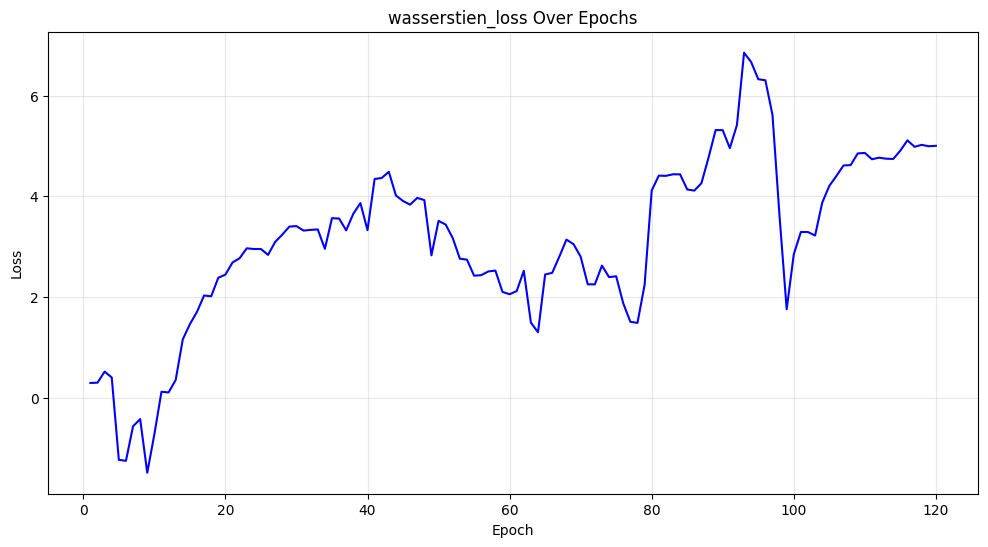

In [8]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(wasserstien_loss) + 1))

plt.figure(figsize=(12, 6))
plt.plot(epochs, wasserstien_loss, 'b-', linewidth=1.5)
plt.title('wasserstien_loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

Increased Filter Size

In [39]:
patch_shape = all_clean_patches[0].shape
model_2 = UWGAN(patch_shape, critic_extra_steps=2, gp_weight=10.0)
history = train_model(model_2, all_noisy_patches, all_clean_patches, batch_size=4, epochs=50)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/stepep - critic_loss: -8.2143 - gen_loss: 8.4144 - l1_loss: 9.4250 - wasserstein_loss: -1.010
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - critic_loss: -8.2574 - gen_loss: 8.4847 - l1_loss: 9.4218 - wasserstein_loss: -0.9371
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - critic_loss: -9.4776 - gen_loss: 8.6537 - l1_loss: 9.3158 - wasserstein_loss: -0.6621
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - critic_loss: -11.0323 - gen_loss: 8.3025 - l1_loss: 9.2939 - wasserstein_loss: -0.9914
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - critic_loss: -14.0596 - gen_loss: 8.2370 - l1_loss: 9.2609 - wasserstein_loss: -1.0238
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/stepep - critic_loss: -13.5909 - gen_loss: 7.9536 - l1_loss: 9.2119 - wasserstein_loss: -1.258
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - critic_loss: -13.6855 - gen_loss: 7.9377 - l1_loss: 9.2109 - wasserstein_loss: -1.2732
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/

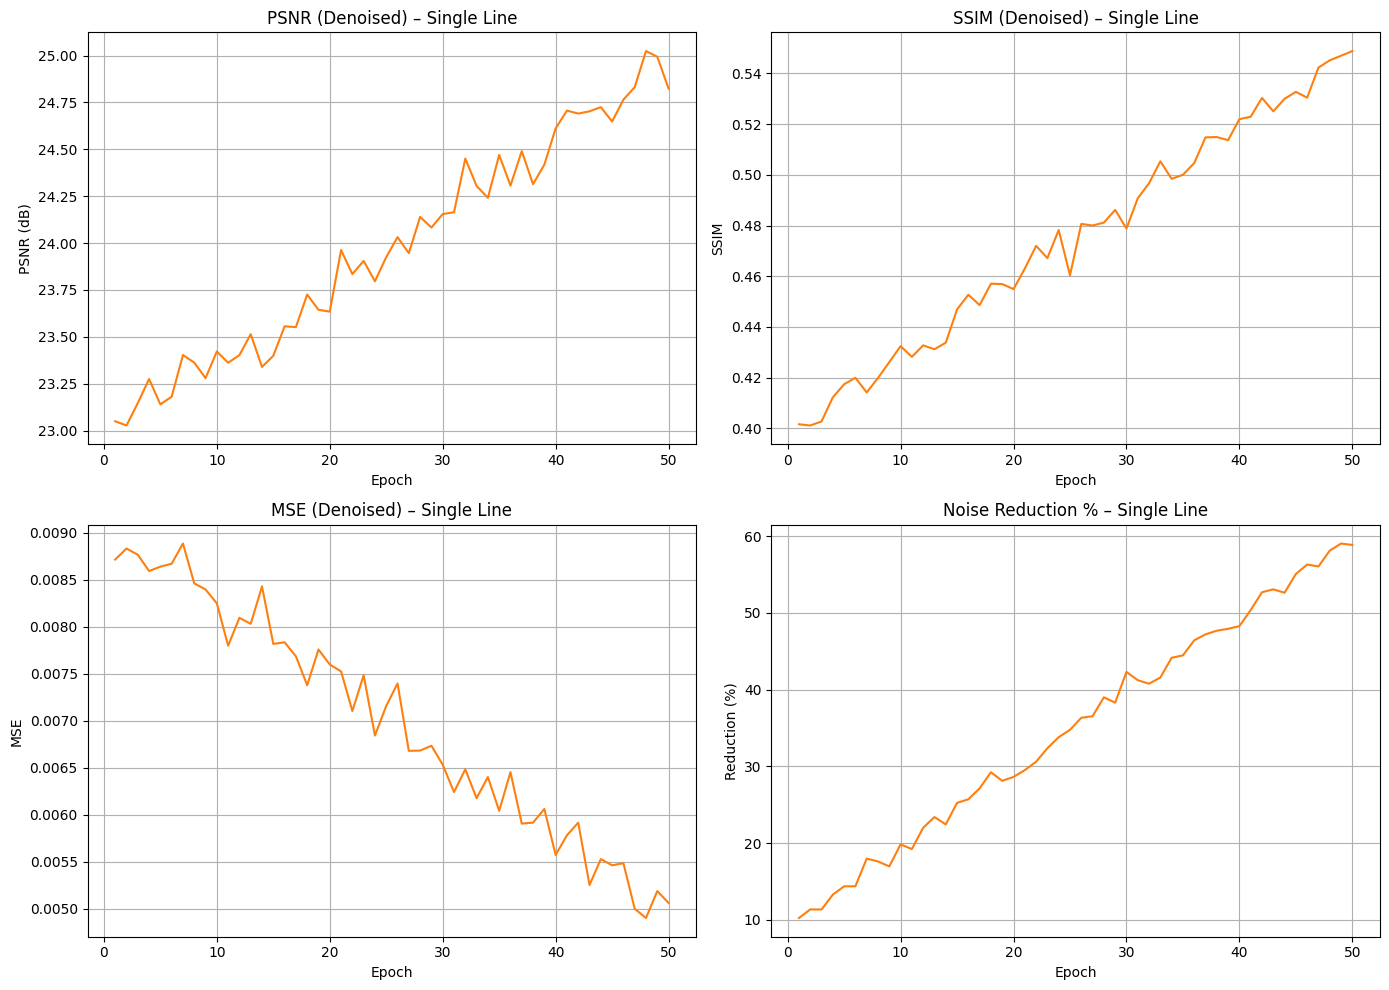

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as sk_psnr
from skimage.metrics import structural_similarity as sk_ssim
from sklearn.metrics import mean_squared_error, mean_absolute_error

N = X_noisy.shape[0]

psnr_vals       = np.zeros(N)
ssim_vals       = np.zeros(N)
mse_vals        = np.zeros(N)
mae_vals        = np.zeros(N)
noise_reduction = np.zeros(N)

X_denoised = model.predict(X_noisy, batch_size=16, verbose=1)

for i in range(N):
    clean   = X_clean[i]
    noisy   = X_noisy[i]
    denoise = X_denoised[i]
    
    psnr_vals[i] = sk_psnr(clean, denoise, data_range=clean.max() - clean.min())
    
    ssim_vals[i] = sk_ssim(clean, denoise, data_range=clean.max() - clean.min(),
                           multichannel=(clean.ndim == 3))
    
    mse_vals[i] = mean_squared_error(clean.ravel(), denoise.ravel())
    mae_vals[i] = mean_absolute_error(clean.ravel(), denoise.ravel())
    
    err_noisy = mean_squared_error(clean.ravel(), noisy.ravel())
    noise_reduction[i] = (err_noisy - mse_vals[i]) / err_noisy * 100

epochs = np.arange(1, N+1)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(epochs, psnr_vals, color='tab:orange')
axs[0, 0].set_title('PSNR (Denoised)')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('PSNR (dB)')
axs[0, 0].grid(True)

axs[0, 1].plot(epochs, ssim_vals, color='tab:orange')
axs[0, 1].set_title('SSIM (Denoised)')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('SSIM')
axs[0, 1].grid(True)

axs[1, 0].plot(epochs, mse_vals, color='tab:orange')
axs[1, 0].set_title('MSE (Denoised)')
axs[1, 0].set_xlabel('Sample Index')
axs[1, 0].set_ylabel('MSE')
axs[1, 0].grid(True)

axs[1, 1].plot(epochs, noise_reduction, color='tab:orange')
axs[1, 1].set_title('Noise Reduction %')
axs[1, 1].set_xlabel('Sample Index')
axs[1, 1].set_ylabel('Reduction (%)')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()